In [33]:
import matplotlib.pyplot as plt # for plotting maps
import maup # mggg's library for proration, see documentation here: https://github.com/mggg/maup
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
from statistics import mean, median
from functools import reduce
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

DATA_PATH = "raw-from-source/"

### **General Summary**

-------

VESTs dataset uses WA's 2018 Election Results and Precinct Boundaries (N rows) for it's shapefile. It only has vote data for the two Senate candidates, Maria Cantwell and Susan Hutchinson. 

In terms of data, their file includes:  

 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  VEST's WA Data Breakdown
 
<font color="Coral">They report that "A dozen votes were reported countywide in King County and Yakima County, these were distributed by candidate to precincts based on their share of the precinct-level reported vote." Not quite sure what this means yet, but will hopefully make sense after a bit of processing. </font>


The two election data columns reported are:

<font color="DeepSkyBlue">
G18USSDCAN - Maria Cantwell (Democratic Party) 
    
G18USSRHUT - Susan Hutchison (Republican Party)
</font>
 
----------

VEST collected data from the [WA Secretary of State](https://www.sos.wa.gov/elections/research/election-results-and-voters-pamphlets.aspx). 

In terms of the WA Secretary of State's data, their files include: \

   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  Sec of State WA Data Breakdown
 
The official data that is found most quickly by visiting the link above, navigating to the "2018 Elections" drop-down, and clicking on "Data", don't seem to contain vote totals for the 2 Senate candidates. Vote total data by county and precinct was instead found on [this page](https://results.vote.wa.gov/results/20181106/export.html) and downloaded directly from [this link](https://results.vote.wa.gov/results/20181106/export/20181106_allcounties.csv), which was found by clicking on the CSV column of the "All Counties" row directly underneatt the "Description" and "County Results" rows on March 8, 2021. 


In [2]:
# Loading partner file, investigating a bit to see the rows/cols
master_partner_df = gp.read_file(DATA_PATH + "VEST-wa-data/wa_2018.shp")

<AxesSubplot:>

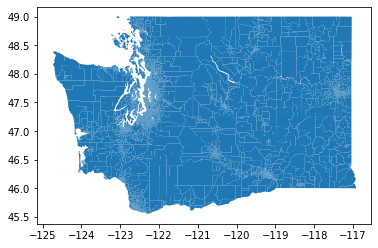

In [3]:
partner_df = master_partner_df.copy()
partner_df.plot()

In [4]:
# General data breakdown
print(f"Columns of VEST Dataset {partner_df.keys()}")
print(f"Number of rows: {len(partner_df)}")
print(f"Number of unique county codes: {len(partner_df['COUNTYCD'].unique())}")
print(f"Number of unique precint codes: {len(partner_df['PRCCODE'].unique())}")
print(f"Number of unique FULLPRC codes: {len(partner_df['FULLPRC'].unique())}")

no_votes = partner_df[(partner_df["G18USSDCAN"] == 0) & (partner_df["G18USSRHUT"] == 0)]
print(f"Number of FULLPRC codes without any votes: {len(no_votes)}")

print('-' * 20)
print(partner_df.head())

Columns of VEST Dataset Index(['COUNTYCD', 'PRCCODE', 'FULLPRC', 'G18USSDCAN', 'G18USSRHUT',
       'geometry'],
      dtype='object')
Number of rows: 7312
Number of unique county codes: 39
Number of unique precint codes: 5140
Number of unique FULLPRC codes: 7312
Number of FULLPRC codes without any votes: 100
--------------------
  COUNTYCD PRCCODE     FULLPRC  G18USSDCAN  G18USSRHUT  \
0       AD     111  AD00000111          38          89   
1       AD     112  AD00000112          36          73   
2       AD     113  AD00000113          59         123   
3       AD     114  AD00000114          58         111   
4       AD     115  AD00000115          55         124   

                                            geometry  
0  POLYGON ((-118.37353 47.13614, -118.37353 47.1...  
1  POLYGON ((-118.37079 47.13292, -118.37098 47.1...  
2  POLYGON ((-118.36870 47.12700, -118.36866 47.1...  
3  POLYGON ((-118.37378 47.12402, -118.37362 47.1...  
4  POLYGON ((-118.37107 47.12031, -118.37097

<AxesSubplot:>

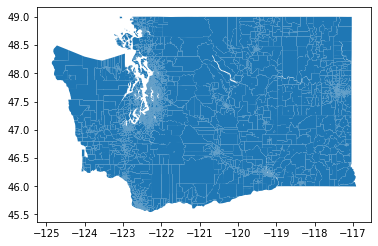

In [5]:
# Load shapeile from WA Sec of State, check it out
master_shape_df = gp.read_file(DATA_PATH + "SoS-2018-general-data/2018Precinct_VERIFIED/2018Precincts_VERIFIED.shp")
master_shape_df.plot()

In [6]:
shape_df = master_shape_df.copy()
print(f"Columns of shape file Dataset {shape_df.keys()}")
print(f"Number of rows: {len(shape_df)}")
print(f"Number of unique county codes: {len(shape_df['CountyCd'].unique())}")
print(f"Number of unique precint codes: {len(shape_df['PrcCode'].unique())}")
print(f"Number of unique FULLPRC codes: {len(shape_df['FullPrc'].unique())}")
print('-' * 20)
print(shape_df.head())

Columns of shape file Dataset Index(['CountyCd', 'PrcCode', 'FullPrc', 'geometry'], dtype='object')
Number of rows: 7336
Number of unique county codes: 39
Number of unique precint codes: 5132
Number of unique FULLPRC codes: 7336
--------------------
  CountyCd PrcCode     FullPrc  \
0       AD     111  AD00000111   
1       AD     112  AD00000112   
2       AD     113  AD00000113   
3       AD     114  AD00000114   
4       AD     115  AD00000115   

                                            geometry  
0  POLYGON ((-118.37353 47.13614, -118.37353 47.1...  
1  POLYGON ((-118.37079 47.13292, -118.37098 47.1...  
2  POLYGON ((-118.36870 47.12700, -118.36866 47.1...  
3  POLYGON ((-118.37378 47.12402, -118.37362 47.1...  
4  POLYGON ((-118.37107 47.12031, -118.37097 47.1...  


##### <font color="LightBlue"> So the VEST dataset and shapefile dataset have the same number of counties, but VEST has has 8 more unique precinct codes and 24 fewer "FullPRC" codes. </font>

##### <font color="LightBlue"> This could be what they were referencing for Yakima and King county?</font>

##### Let's see which/how many county/precinct codes are actually different

In [7]:
different_fullprc_1 = partner_df[~partner_df["FULLPRC"].isin(shape_df["FullPrc"])]
different_fullprc_2 = shape_df[~shape_df["FullPrc"].isin(partner_df["FULLPRC"])]
print(len(different_fullprc_1))
print(len(different_fullprc_2))
print(different_fullprc_1["FULLPRC"].tolist())
print(different_fullprc_2["FullPrc"].tolist())

11
35
['OKC0000017', 'OKC0000179', 'OKC0000187', 'OKC0000200', 'OKC0000225', 'OKC0000025', 'OKC0000028', 'OKC0000031', 'OKC0000004', 'OKC0000073', 'WM00000270']
['OK00000100', 'OK00000139', 'OK00000151', 'OK00000017', 'OK00000179', 'OK00000187', 'OK00000200', 'OK00000212', 'OK00000225', 'OK00000227', 'OK00000228', 'OK00000230', 'OK00000232', 'OK00000233', 'OK00000235', 'OK00000238', 'OK00000025', 'OK00000026', 'OK00000028', 'OK00000300', 'OK00000031', 'OK00000033', 'OK00000034', 'OK00000004', 'OK00000041', 'OK00000050', 'OK00000055', 'OK00000069', 'OK00000070', 'OK00000073', 'OK00000074', 'OK00000080', 'OK00000089', 'OK00000009', 'OK00000096']


##### It seems that one county was changed from "OK" to "OKC" in VEST. 

<font color="red"> Is this worth brining up to #dataintegrity? Maybe a mistake in VEST </font>

Nope, this is just because "OK" became "OK" "combined". 

In [9]:
# nope, it looks like the counties are truly the same
print(f"County codes are equal?", sorted(partner_df["COUNTYCD"].unique()) == sorted(shape_df["CountyCd"].unique()))
print(f"County codes:", sorted(partner_df["COUNTYCD"].unique())) 

County codes are equal? True
County codes: ['AD', 'AS', 'BE', 'CH', 'CM', 'CR', 'CU', 'CZ', 'DG', 'FE', 'FR', 'GA', 'GR', 'GY', 'IS', 'JE', 'KI', 'KP', 'KS', 'KT', 'LE', 'LI', 'MA', 'OK', 'PA', 'PE', 'PI', 'SJ', 'SK', 'SM', 'SN', 'SP', 'ST', 'TH', 'WK', 'WL', 'WM', 'WT', 'YA']


In [10]:
# To be applied to the FULLPRC column of partner_df, cuts out the "C" of "OKC"
modify_fnc = lambda x: x[:2] + "0" + x[3:] if x.startswith('OKC') else x

partner_df["FULLPRC"] = partner_df["FULLPRC"].apply(modify_fnc)

# Redo difference calculations from before
different_fullprc_1 = partner_df[~partner_df["FULLPRC"].isin(shape_df["FullPrc"])]
different_fullprc_2 = shape_df[~shape_df["FullPrc"].isin(partner_df["FULLPRC"])]
print(len(different_fullprc_1))
print(len(different_fullprc_2))
print(different_fullprc_1["FULLPRC"].tolist())
print(different_fullprc_2["FullPrc"].tolist())

1
25
['WM00000270']
['OK00000100', 'OK00000139', 'OK00000151', 'OK00000212', 'OK00000227', 'OK00000228', 'OK00000230', 'OK00000232', 'OK00000233', 'OK00000235', 'OK00000238', 'OK00000026', 'OK00000300', 'OK00000033', 'OK00000034', 'OK00000041', 'OK00000050', 'OK00000055', 'OK00000069', 'OK00000070', 'OK00000074', 'OK00000080', 'OK00000089', 'OK00000009', 'OK00000096']


<AxesSubplot:>

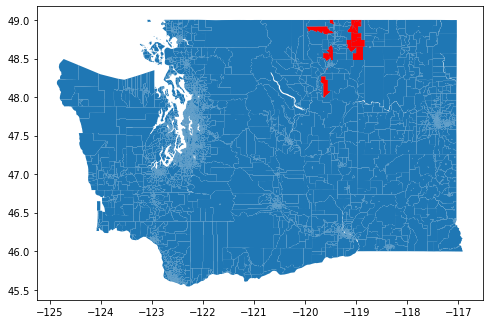

In [11]:
# All the differences seem to appear in Okanogan county, maybe the population there is 0?
fig, ax = plt.subplots(figsize=(8,8))
shape_df.plot(ax=ax)
different_fullprc_2.plot(ax=ax, color="red")

<AxesSubplot:>

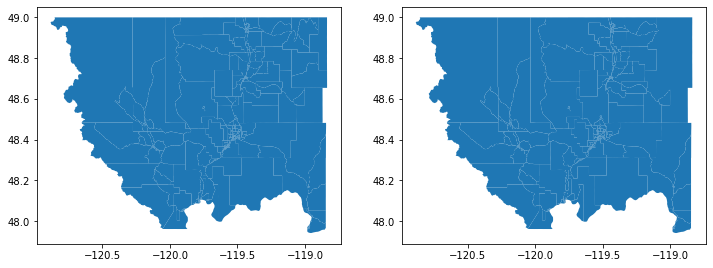

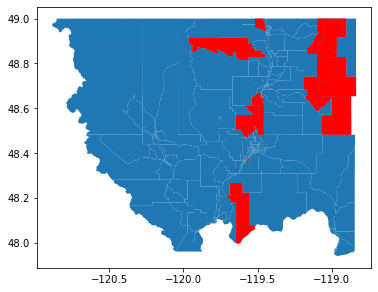

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12,12))
shape_df[shape_df["CountyCd"] == "OK"].plot(ax=ax[0])
partner_df[partner_df["COUNTYCD"] == "OK"].plot(ax=ax[1])

fig, ax = plt.subplots(figsize=(6,6))
shape_df[shape_df["CountyCd"] == "OK"].plot(ax=ax)
different_fullprc_2.plot(ax=ax, color="red")

<AxesSubplot:>

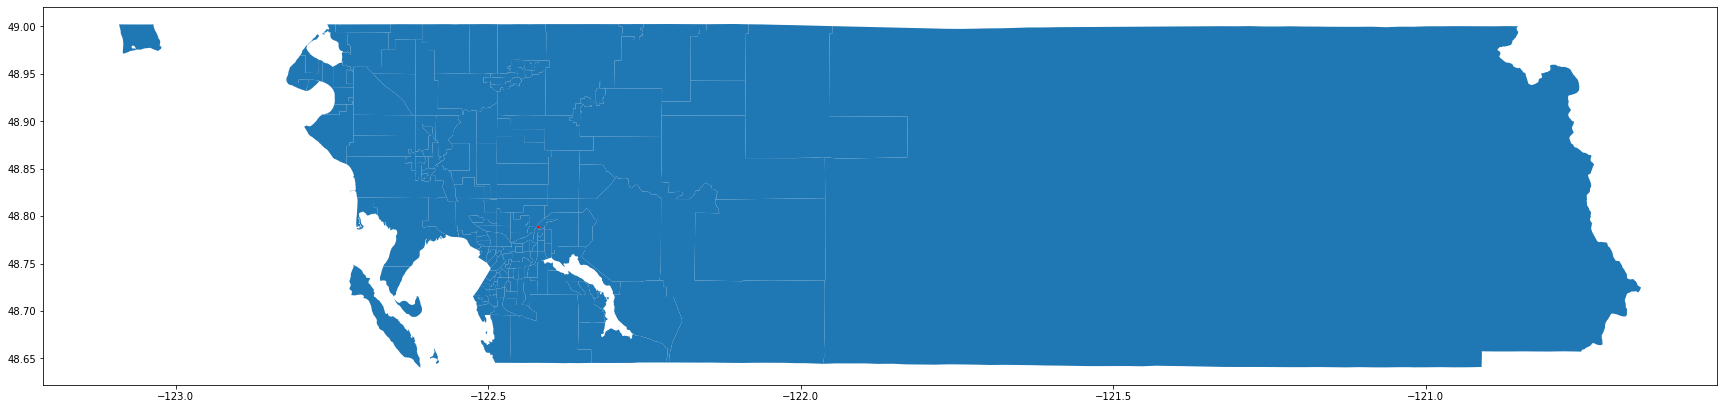

In [13]:
fig, ax = plt.subplots(figsize=(30,10))

# Plotting Winnemucca county
shape_df[shape_df["CountyCd"] == "WM"].plot(ax=ax)
different_fullprc_1.plot(ax=ax, color="red")
# There is a super small extra district within WM for the partner data

##### So the data partners merged a few clusters of precincts together in Okanogan, which is likely why they renamed it from "OK" to "OKC"

### Now we will look at downloaded election data, but we are a bit worried because there seem to be less FULLPRC in the precinct data than in the partner and shapefile data:

In [14]:
# Load source file from WA Sec of State, check it out
master_election_df = pd.read_csv(DATA_PATH + "direct-download/20181106_allstateprecincts.csv")
master_election_df.head()

,Race,CountyCode,Candidate,PrecinctName,PrecinctCode,Votes
0,U.S. Senator,AD,Maria Cantwell,Total,-1,1365
1,U.S. Senator,AD,Susan Hutchison,Total,-1,2867
2,U.S. Senator,AD,Maria Cantwell,Ritzville Ward #1,111,38
3,U.S. Senator,AD,Susan Hutchison,Ritzville Ward #1,111,89
4,U.S. Senator,AD,Maria Cantwell,Ritzville Ward #2,112,36


In [15]:
# Join election results to shapefile
election_df = master_election_df.copy()
# No precinct-level data reported for KI, otherwise filter out
# the summary "Total" rows
election_df = election_df[(election_df["PrecinctCode"] != -1) ^ (election_df["CountyCode"] == "KI")]
election_df["PrecinctCode"] = election_df["PrecinctCode"].astype('str')

print(len(shape_df["CountyCd"].unique()))
print(len(partner_df["COUNTYCD"].unique()))
print(len(election_df["CountyCode"].unique()))

print(len(election_df), len(shape_df), len(partner_df))
print("Election DF is much much longer, 2 entries for each precinct and summary rows as well")

same_counties = sorted(election_df["CountyCode"].unique()) == sorted(partner_df["COUNTYCD"].unique())

print(f"Election counties equal shape and partner counties? {same_counties}")

39
39
39
193186 7336 7312
Election DF is much much longer, 2 entries for each precinct and summary rows as well
Election counties equal shape and partner counties? True


In [17]:
# Let's see if there are the same number of precinct codes associated with each county
from collections import defaultdict

# counties to precinct lists
def calc_c2p_all(shape, election, partner):
    """
    Used to quickly compare the precint names between
    all 3 dataframes as standardizations are applied
    """
    c2p_shape = shape_df.groupby("CountyCd")["PrcCode"].apply(np.unique).apply(list).apply(sorted)
    c2p_election = election_df.groupby("CountyCode")["PrecinctCode"].apply(np.unique).apply(list).apply(sorted)
    c2p_partner = partner_df.groupby("COUNTYCD")["PRCCODE"].apply(np.unique).apply(list).apply(sorted)
    
    c2p_all = pd.concat([c2p_shape, c2p_election, c2p_partner], axis=1)

    new_names = {
        "PrcCode" : "shape_df",
        "PrecinctCode" : "election_df",
        "PRCCODE" : "partner_df"
    }

    c2p_all.rename(columns=new_names, inplace=True)
    
    return c2p_all

c2p_all = calc_c2p_all(shape_df, election_df, partner_df)

#### Alright, so we are going to have to do some serious precinct renaming. First, let's standardize across the partner_df and shape_df

In [18]:
precinct_names = np.array(c2p_all.index)
partner_precincts = c2p_all["partner_df"].to_numpy()
shape_precincts = c2p_all["shape_df"].to_numpy()

print("The precinct names are different between partner and shape", precinct_names[partner_precincts != shape_precincts])
print("Great! This is what we expected and saw from before")

The precinct names are different between partner and shape ['OK' 'WM']
Great! This is what we expected and saw from before


In [60]:
# This cell modifies our election_df's county columns for counties
# that have the same number of precinct names as the other dataframes, 
# so the only modifications needed are slight alterations. 
# These are counties FR, KP, and TH
election_df = master_election_df.copy()
election_df = election_df[(election_df["PrecinctCode"] != -1) ^ (election_df["CountyCode"] == "KI")]
election_df["PrecinctCode"] = election_df["PrecinctCode"].astype('str')

# Precinct names in county 'FR' need to be of length 3
election_df["PrecinctCode"] = np.where(election_df["CountyCode"] == "FR", 
                                       election_df["PrecinctCode"].str.rjust(3, '0'), 
                                         election_df["PrecinctCode"])

# Precinct names in county 'KP' need to have leading 1s stripped and then 0s stripped
election_df["PrecinctCode"] = np.where(election_df["CountyCode"] == "KP", 
                                        election_df["PrecinctCode"].str.lstrip('1'), 
                                          election_df["PrecinctCode"])
election_df["PrecinctCode"] = np.where(election_df["CountyCode"] == "KP", 
                                        election_df["PrecinctCode"].str.lstrip('0'), 
                                          election_df["PrecinctCode"])

# Precinct names in county 'TH' need to be of len 3 with leading 0s
election_df["PrecinctCode"] = np.where(election_df["CountyCode"] == "TH", 
                                       election_df["PrecinctCode"].str.rjust(3, '0'), 
                                          election_df["PrecinctCode"])

# Precinct name in "GY" need to be length 3
election_df["PrecinctCode"] = np.where(election_df["CountyCode"] == "GY", 
                                       election_df["PrecinctCode"].str.rjust(3, '0'), 
                                          election_df["PrecinctCode"])

# Precinct name in "PI" needs to be of length 5 and have a dash in between the 2nd and 
# 3rd character
election_df["PrecinctCode"] = np.where(election_df["CountyCode"] == "PI", 
                                       election_df["PrecinctCode"].str.rjust(5, '0'), 
                                          election_df["PrecinctCode"])
election_df["PrecinctCode"] = np.where(election_df["CountyCode"] == "PI", 
                                       election_df["PrecinctCode"].str.slice(0,2) + '-' + election_df["PrecinctCode"].str.slice(2).str.rjust(3, '0'), 
                                          election_df["PrecinctCode"])

c2p_all = calc_c2p_all(shape_df, election_df, partner_df)

In [71]:
# This cell will be to identify the changes made between the
# precincts of the election_df and shape_df
def diagnose_precinct_diff(election_df, shape_df, partner_df, county, verbose=False):
    
    e = election_df[election_df["CountyCode"] == county]
    s = shape_df[shape_df["CountyCd"] == county]
    p = partner_df[partner_df["COUNTYCD"] == county]
    
    e_ps = e["PrecinctCode"].unique()
    s_ps = s["PrcCode"].unique()
    
    diff_es = list(set(e_ps).difference(set(s_ps)))
    diff_se = list(set(s_ps).difference(set(e_ps)))
    
    if verbose:
        print("In election but not shape", diff_es)
        print('-' * 20)
        print("In shape but not election", diff_se)
    
        print("The data rows in shape_df and partner_df that aren't precincts in election_df")
        
        fig, ax = plt.subplots(figsize=(6,6))
        s.plot(ax=ax)
        s[s["PrcCode"].isin(diff_se)].plot(ax=ax, color="red")

        display(p[p["PRCCODE"].isin(diff_se)]["G18USSDCAN"])
        display(p[p["PRCCODE"].isin(diff_se)]["G18USSRHUT"])
    
    missed_votes = p[p["PRCCODE"].isin(diff_se)]["G18USSDCAN"].sum() + \
                    p[p["PRCCODE"].isin(diff_se)]["G18USSRHUT"].sum()
    if verbose:
        print("Do all non-included precincts have 0 counted votes?", (missed_votes == 0))
        
    return missed_votes == 0


In [74]:
# So for all counties except OK and WM, we can modify the precinct names
different_precincts = []
for i in range(len(c2p_all)):
    row = c2p_all.iloc[i]
    name = row.name
    
    if name in ["OK", "WM", "KI"]:
        continue
        
    e_ps = row["election_df"]
    p_ps = row["partner_df"]
    
    e_ps = [str(elem) for elem in e_ps]
    p_ps = [str(elem) for elem in p_ps]
    
    
    if sorted(e_ps) != sorted(p_ps):
        different_precincts.append((name, (len(e_ps), len(p_ps))))
        
# print(different_precincts)
# print(len(different_precincts), len(c2p_all))

to_convert = [elem[0] for elem in different_precincts if elem[1][0] == elem[1][1]]
# print("List of counties where number of precincts are the same but have different naming conventions", to_convert)

#display(c2p_all)

for county in to_convert:
    if not diagnose_precinct_diff(election_df, shape_df, partner_df, county):
        print(f"County {county} is still off")
    

In [75]:
# Now we need to see what's going on with King County and Yakima

In [ ]:
# Filter out the summary rows, these aggregate county-wide vote totals
# and will be redundant for our purposes
election_df = election_df[election_df["PrecinctCode"] != -1]

# Common column for merge, precinct ID formatted same way as .shp
election_df["FullPrc"] = election_df["CountyCode"] + \
                            election_df["PrecinctCode"].astype('str').str.rjust(8, "0")

In [47]:
shape_df = master_shape_df.copy()

# print(shape_df["FullPrc"])
# print(election_df["FullPrc"])

print(len(partner_df["PRCCODE"].unique()))
print(len(shape_df["PrcCode"].unique()))
print(len(election_df["PrecinctCode"].unique()))

# Let's see all the ones that don't match 
#print(len(election_df[~election_df["FullPrc"].isin(shape_df["FullPrc"])]["FullPrc"]))


print(shape_df.shape)
print(election_df.shape)
shape_df = shape_df.merge(election_df, how="outer", on="FullPrc")
print(shape_df.shape)

5140
5132
2761
(7336, 4)
(193013, 7)
(195905, 10)


In [6]:
# Join partner data to re-created source data


In [7]:
# Validate Election Results

In [8]:
# Validate Geographies

In [ ]:
# Profit